# Setup

In [1]:
!pip install trackio -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.0/875.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Libraries and imports

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn.functional as F
from tqdm import tqdm
import trackio
import torchmetrics
import torch.optim as optim

In [3]:
# Huggingface Access Adding token to environment variable
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
import os
os.environ['HF_TOKEN']  = user_secrets.get_secret("hf_token")

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Data Loaders/ Lightning DataModule (with optional data augmentation)

In [5]:
from pathlib import Path
DATA_DIR = Path('/kaggle/input/sep-25-dl-gen-ai-nppe-1/face_dataset/')
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [6]:
train_df

,id,full_path,gender,age
0,0,train/00000.jpg,1,66
1,1,train/00001.jpg,1,53
2,2,train/00002.jpg,1,20
3,3,train/00003.jpg,1,32
4,4,train/00004.jpg,1,21
...,...,...,...,...
34703,34703,train/34703.jpg,1,32
34704,34704,train/34704.jpg,1,28
34705,34705,train/34705.jpg,1,25
34706,34706,train/34706.jpg,1,19


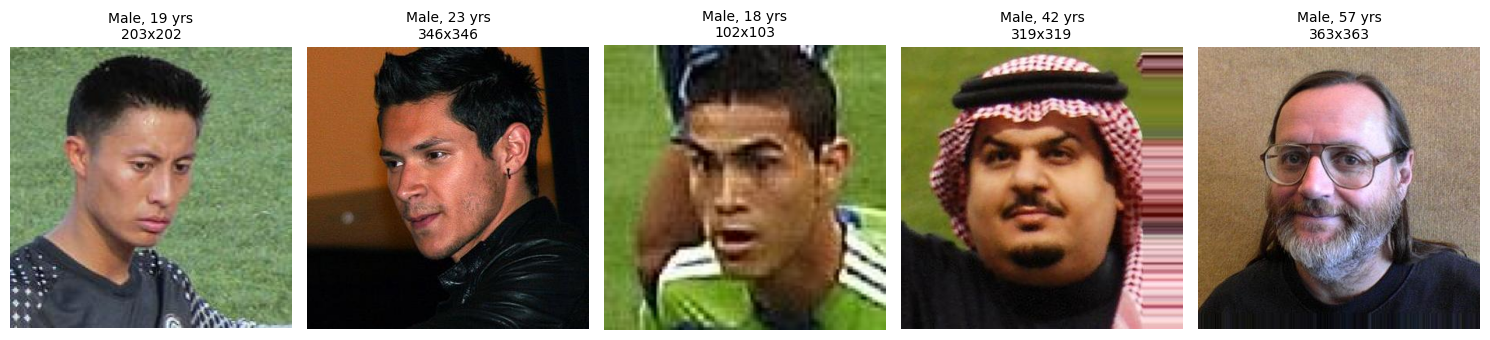

In [7]:
"Just to have a look of images and their dimensions"
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd


sample_df = train_df.sample(5)

plt.figure(figsize=(15, 6))

for i in range(5):
    img_path = os.path.join(DATA_DIR, sample_df.iloc[i]['full_path'])
    image = Image.open(img_path).convert('RGB')
    
    
    width, height = image.size
    
    
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    gender_label = 'Male' if sample_df.iloc[i]['gender'] == 1 else 'Female'
    age = sample_df.iloc[i]['age']
    plt.title(f"{gender_label}, {age} yrs\n{width}x{height}", fontsize=10)

plt.tight_layout()
plt.show()


In [8]:
"Pytorch Custom Dataset"
class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['full_path'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, row['id']

        gender = torch.tensor(row['gender'], dtype=torch.long)
        age = torch.tensor(row['age'], dtype=torch.float32)
        return image, gender, age

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),                      
    transforms.CenterCrop(224),                         
    transforms.RandomHorizontalFlip(p=0.5),             
    transforms.ColorJitter(                             
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],                     
        std=[0.229, 0.224, 0.225]
    ),
])



train_dataset = FaceDataset(train_df, DATA_DIR, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [10]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

# Model Architecture

## Scratch CNN


In [11]:
class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()

        '''Defining Convolutional Layers having input is (3, 224, 224), 3 channel with 224*224 each channel height and width'''

    
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)     #  (64, 224, 224)
        self.pool1 = nn.MaxPool2d(2, 2)                             #  (64, 112, 112)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   #  (128, 112, 112)
        self.pool2 = nn.MaxPool2d(2, 2)                             #  (128, 56, 56)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  #  (256, 56, 56)
        self.pool3 = nn.MaxPool2d(2, 2)                             # (256, 28, 28)
        
        '''Defining Fully Connected Layers having input is (256 * 28 * 28), 256 channel with 28*28 each channel height and width'''
        
        self.fc1 = nn.Linear(256 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc_gender = nn.Linear(128, 2)   # as gender is a binary either 0,1 
        self.fc_age = nn.Linear(128, 1)      # in this case age is contineous or its a regression

    def forward(self, x):
        
        '''Feature Extraction'''
        
        x = F.relu(self.conv1(x))    # (64, 224, 224)
        x = self.pool1(x)            # (64, 112, 112)

        x = F.relu(self.conv2(x))    # (128, 112, 112)
        x = self.pool2(x)            # (128, 56, 56)

        x = F.relu(self.conv3(x))    # (256, 56, 56)
        x = self.pool3(x)            # (256, 28, 28)

        #  Flatten 
        x = x.view(x.size(0), -1)    # (batch_size, 256*28*28)

        # Fully Connected Head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Two outputs
        gender_out = torch.sigmoid(self.fc_gender(x))  # 2 classes: Male/Female
        age_out = self.fc_age(x).squeeze(1)            # (batch_size, 1)

        return gender_out, age_out

## Finetuned CNN

In [12]:
# base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [13]:
# from torchsummary import summary
# model = base_model.to(device)
# summary(model=model, input_size=(3, 224, 224))

In [14]:
import torch
import torch.nn as nn
from torchvision import models

class FinetunedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        '''using base model for transfer learning'''
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        n_features = base.fc.in_features

        '''Removing  the original Classification layer'''
        base.fc = nn.Identity()
        self.base = base

        '''Ereezing all base model pretrained parameters'''
        for param in self.base.parameters():
            param.requires_grad = False

        '''adding new trainable head'''
        self.gender_head = nn.Linear(n_features, 2)
        self.age_head = nn.Linear(n_features, 1)

    def forward(self, x):
        '''feature extraction wiht freezed weiths of base model'''
        features = self.base(x)
        
        gender = self.gender_head(features)
        age = self.age_head(features).squeeze(1)
        return gender, age


In [15]:
model= FinetunedCNN().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


# Loss Function, Optimizer, and Metrics

In [16]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.L1Loss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using 2 GPUs


# Training Loop definition (or LightningModule)

In [17]:
def train_model(model, train_loader, optimizer, criterion_gender, criterion_age, device, epochs=5):
    """
    Train pipeline wiht loggin on trackio
    """
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_loss_g = 0.0
        total_loss_a = 0.0

        for images, genders, ages in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move data to device
            images, genders, ages = images.to(device), genders.to(device), ages.to(device)

            # Forward pass
            pred_gender, pred_age = model(images)

            # Compute losses
            loss_g = criterion_gender(pred_gender, genders)
            loss_a = criterion_age(pred_age, ages)
            loss = loss_g + 0.4*loss_a

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_loss_g += loss_g.item()
            total_loss_a += loss_a.item()

        # Compute averages
        avg_loss = total_loss / len(train_loader)
        avg_loss_g = total_loss_g / len(train_loader)
        avg_loss_a = total_loss_a / len(train_loader)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Total: {avg_loss:.4f} | Gender: {avg_loss_g:.4f} | Age: {avg_loss_a:.4f}")

        # Log metrics to Trackio (if available)
        trackio.log({
                "epoch": epoch + 1,
                "epoch_loss": avg_loss,
                "epoch_gender_loss": avg_loss_g,
                "epoch_age_loss": avg_loss_a
            })



## Trackio Initialization and logging

In [18]:
# trackio.init(project="25-t3-nppe1", space_id="udit789/dlgenai-nppe",name="FinetunedCNN_resnet50",group="Raw")

## Training execution

In [19]:
# '''This block of code used when im usign the finetuned CNN , after trainting it by keepung base model params freezed, i will train it for next 5-8 epochs wiht full parameters tuning including the parameterws of base model '''

# for param in model.module.parameters():
#     param.requires_grad = True
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [20]:
# train_model(model, train_loader, optimizer, criterion_gender, criterion_age, device, epochs=10)

In [21]:
# trackio.finish()

## Model upload to kagglehub

In [22]:
import kagglehub

In [23]:
# model_path = "/kaggle/working/FinetunedCNN_resnet50.pth"

# '''# have used DataParallel, saving the module's weights'''
# torch.save(model.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(), model_path)

# print("Model saved locally at:", model_path)


In [24]:
# KAGGLE_USERNAME = "uditmaurya1588"     # your Kaggle username
# MODEL = "models"              # project/model name
# FRAMEWORK = "pytorch"                  # framework
# VARIATION = "resnet18-v5"              # version or hyperparameter variant

# handle = f"{KAGGLE_USERNAME}/{MODEL}/{FRAMEWORK}/{VARIATION}"

In [25]:
# kagglehub.model_upload(
#     handle,
#     model_path,
#     version_notes="Initial model version"
# )

# Inference Code

In [26]:

handle = "uditmaurya1588/models/pytorch/resnet18-v2"
model_path = kagglehub.model_download(handle)
print("Downloaded:", model_path)


Downloaded: /kaggle/input/models/pytorch/resnet18-v2/1


## Load the uploaded model from kagglehub

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = FinetunedCNN().to(device)


model_file = '/kaggle/input/models/pytorch/resnet18-v2/1/FinetunedCNN_resnet18.pth'
state_dict = torch.load(model_file, map_location=device)

# fix 'module.' prefix if trained with DataParallel
if any(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)

print("Model loaded and ready for predictions.")

Model loaded and ready for predictions.


In [28]:
test_dataset = FaceDataset(test_df, DATA_DIR, transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        gender_logits, age_preds = model(images)

        gender_preds = torch.argmax(gender_logits, dim=1).cpu().numpy()
        age_preds = age_preds.cpu().numpy()

        # Convert ids to plain ints here
        ids = ids.cpu().numpy() if torch.is_tensor(ids) else ids

        for i in range(len(ids)):
            predictions.append([int(ids[i]), int(gender_preds[i]), float(age_preds[i])])

Predicting: 100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


## Test Prediction/Inference to create the submission CSV.

In [29]:
submission = pd.DataFrame(predictions, columns=['id', 'gender', 'age'])
submission = submission.sort_values(by='id')
submission.to_csv('submission.csv', index=False)

print("submission.csv created successfully!")
submission.head()


submission.csv created successfully!


,id,gender,age
0,0,1,31.973970
1,1,0,23.701078
2,2,1,27.191149
3,3,1,26.751059
4,4,1,58.387211
